# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля. 

Постройте модель, которая умеет её определять. В вашем распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей.

Критерии, которые важны заказчику:

- качество предсказания;
- время обучения модели;
- время предсказания модели.

## Описание данных

**Признаки**

- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `Repaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя

**Целевой признак**

- `Price` — цена (евро)


# Необходимы импорты

In [ ]:
!pip install --upgrade pandas dask lightgbm seaborn scikit-learn -q
!pip install phik shap -q

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import shap
import phik
import time

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


# загружаем класс pipeline
from sklearn.pipeline import Pipeline
# загружаем классы для подготовки данных
from sklearn.preprocessing import OneHotEncoder, StandardScaler, TargetEncoder
from sklearn.compose import ColumnTransformer


# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем функцию для работы с метриками
from sklearn.metrics import roc_auc_score, roc_curve, make_scorer, r2_score, mean_absolute_error, root_mean_squared_error

# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV


# загружаем нужные модели
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC, LinearSVR
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import lightgbm as lgb

from sklearn.exceptions import ConvergenceWarning 


import warnings
from IPython.display import Markdown as md
warnings.simplefilter('ignore', DeprecationWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [3]:
RANDOM_STATE = 42
TEST_SIZE = .25
DEFAULT_COLOR = '#8174A0'

sns.set_theme()

In [4]:
def analyze_residuals(residuals, predictions, model_string=None):
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
    sns.histplot(residuals, ax=axes[0], color='#ECDBBA', bins=20)
    
    if model_string is not None:
        axes[0].set_title(f'Гистограмма распределения остатков [{model_string}]')
    else:
        axes[0].set_title(f'Гистограмма распределения остатков')
        
    axes[0].axvline(x=residuals.mean(), label='среднее', color='red', ls='--')
    axes[0].axvline(x=0, label='нулевой уровень', color='green')
    
    axes[0].legend()
    axes[0].set_xlabel('Остатки')

    axes[1].scatter(predictions, residuals)
    
    axes[1].axhline(y=0, color='red', ls='--')
    
    axes[1].set_xlabel('Предсказания модели')
    axes[1].set_ylabel('Остатки')
    if model_string is not None:
        axes[1].set_title(f'Анализ дисперсии [{model_string}]')
    else:
        axes[1].set_title(f'Анализ дисперсии')
        
    plt.show()

In [5]:
def plot_graphics(df, 
                  column_name, 
                  test_df=None, 
                  bins=30, 
                  range_hist=None, 
                  hist_color='#519872', 
                  boxplot_color='#B9D2D2', 
                  col_alias='', 
                  xlabel='', 
                  ylabel='', 
                  figsize=(10, 10)):
    
    if test_df is not None:
        fig, ax = plt.subplots(2, 2, figsize=figsize)
        ax = ax.flatten()
    
        ax1 = sns.histplot(data=df, x=column_name, ax=ax[0], bins=bins, binrange=range_hist, color=hist_color)
        ax1.set_title(f'[Train] Гистограмма столбца {col_alias if len(col_alias) > 0 else column_name}')
    
        ax2 = sns.boxplot(data=df, x=column_name, ax=ax[1], color=boxplot_color)
        ax2.set_title(f'[Train] Коробчатая диаграмма столбца {col_alias if len(col_alias) > 0 else column_name}')

    
        ax1.set_xlabel(xlabel if len(xlabel) > 0 else 'Значения')
        ax1.set_ylabel(ylabel if len(ylabel) > 0 else 'Количество')
        ax2.set_xlabel(xlabel if len(xlabel) > 0 else 'Значения')
        
        ax1 = sns.histplot(data=test_df, x=column_name, ax=ax[2], bins=bins, binrange=range_hist, color=hist_color)
        ax1.set_title(f'[Test] Гистограмма столбца {col_alias if len(col_alias) > 0 else column_name}')
    
        ax2 = sns.boxplot(data=test_df, x=column_name, ax=ax[3], color=boxplot_color)
        ax2.set_title(f'[Test] Коробчатая диаграмма столбца {col_alias if len(col_alias) > 0 else column_name}')

    
        ax1.set_xlabel(xlabel if len(xlabel) > 0 else 'Значения')
        ax1.set_ylabel(ylabel if len(ylabel) > 0 else 'Количество')
        ax2.set_xlabel(xlabel if len(xlabel) > 0 else 'Значения')
        return 

        
    fig, ax = plt.subplots(1, 2, figsize=figsize)
    
    ax1 = sns.histplot(data=df, x=column_name, ax=ax[0], bins=bins, binrange=range_hist, color=hist_color)
    ax1.set_title(f'Гистограмма столбца {col_alias if len(col_alias) > 0 else column_name}')
    
    ax2 = sns.boxplot(data=df, x=column_name, ax=ax[1], color=boxplot_color)
    ax2.set_title(f'Коробчатая диаграмма столбца {col_alias if len(col_alias) > 0 else column_name}')

    
    ax1.set_xlabel(xlabel if len(xlabel) > 0 else 'Значения')
    ax1.set_ylabel(ylabel if len(ylabel) > 0 else 'Количество')
    ax2.set_xlabel(xlabel if len(xlabel) > 0 else 'Значения') 

# Загрузка данных

In [ ]:
try:
    autos = pd.read_csv('/datasets/autos.csv')
except:
    autos = pd.read_csv('path')

In [11]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [12]:
autos.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


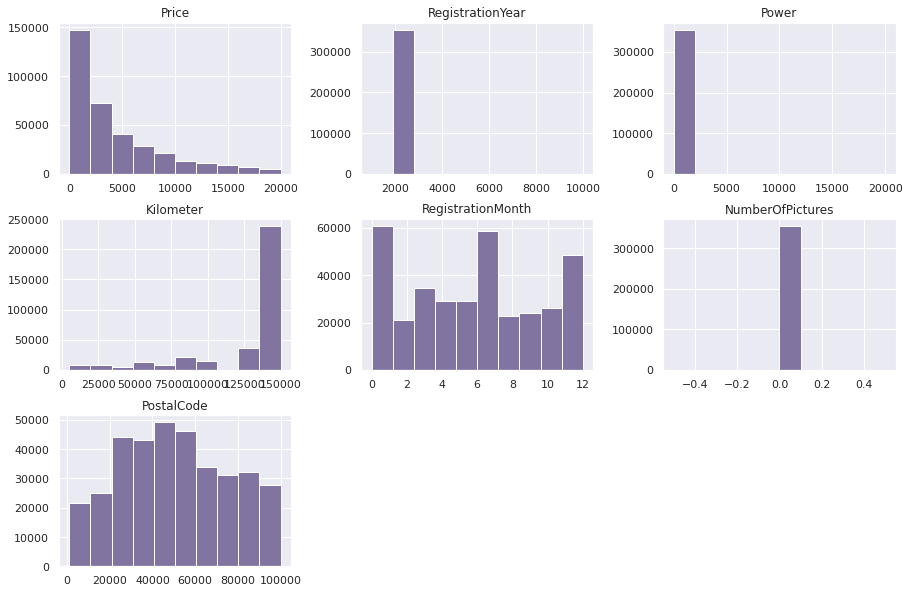

In [13]:
autos.hist(figsize=(15,10), color=DEFAULT_COLOR);

- Первичный анализ гистограмм обнаруживает явные выбросы в столбцах `RegistrationYear`, `Power` и `NumberOfPictures`
- Гистограммы `Price` и `Kilometer` выглядят тоже подозрительно. Видны хвосты справа и слева соответственно

In [14]:
autos = autos.rename(columns={
    'DateCrawled': 'date_crawled',
    'Price': 'price',
    'VehicleType': 'vehicle_type',
    'RegistrationYear': 'registration_year',
    'Gearbox': 'gearbox',
    'Power': 'power',
    'Model': 'model',
    'Kilometer': 'kilometer',
    'RegistrationMonth': 'registration_month',
    'FuelType': 'fuel_type',
    'Brand': 'brand',
    'Repaired': 'repaired',
    'DateCreated': 'date_created',
    'NumberOfPictures': 'number_of_pictures',
    'PostalCode': 'postal_code',
    'LastSeen': 'last_seen',
})

In [15]:
autos['last_seen'] = pd.to_datetime(autos['last_seen'])
autos['date_crawled'] = pd.to_datetime(autos['date_crawled'])
autos['date_created'] = pd.to_datetime(autos['date_created'])

## Исследование пропусков

In [16]:
missings = pd.concat([autos.isna().sum().T,  autos.isna().mean().T * 100], axis=1).set_axis(['Количество пропусков','Процент пропусков'], axis=1).round(2)

визуализируем данные на столбчатой диаграмме

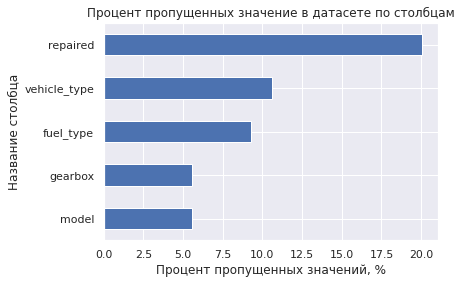

In [17]:
(missings.loc[missings['Процент пропусков'] > 0, 'Процент пропусков']
 .sort_values()
 .plot(kind='barh', title='Процент пропущенных значение в датасете по столбцам'))
plt.xlabel('Процент пропущенных значений, %')
plt.ylabel('Название столбца');

- Видим, что около 20 процентов данных в столбце Repaired - пропуски, это весомое число
- Также от 5 до 12 процентов пропусков есть в столбцах с типом кузова, типом топлива, типом коробки передач и моделью автомобиля

In [18]:
autos['model'].value_counts()

model
golf                  29232
other                 24421
3er                   19761
polo                  13066
corsa                 12570
                      ...  
i3                        8
serie_3                   4
rangerover                4
range_rover_evoque        2
serie_1                   2
Name: count, Length: 250, dtype: int64

In [19]:
autos['repaired'].value_counts()

repaired
no     247161
yes     36054
Name: count, dtype: int64

In [20]:
autos['fuel_type'].value_counts()

fuel_type
petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: count, dtype: int64

In [21]:
autos['gearbox'].value_counts()

gearbox
manual    268251
auto       66285
Name: count, dtype: int64

In [22]:
autos['vehicle_type'].value_counts()

vehicle_type
sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: count, dtype: int64

- Итак, проанализировав пропуски в данных приходим к выводу, что их нельзя заполнить уже существующей категорией, например, `other`, так как среди пропусков могли быть вполне конкретные данные о тех или иных признаках. 
- Заполнив их как `other`, мы рискуем необоснованно расширить эту группу. Поэтому все пропуски в категориальных столбцах будем заполнять значением `no_data`

In [23]:
autos.fillna(
    'no_data',
    inplace=True
)

## Исследование на явные дубликаты

In [24]:
autos[autos.duplicated()]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18,0,36391,2016-03-18 18:46:15


In [25]:
autos = autos.drop_duplicates()

- Дубликатов немного, поэтому можно удалить их

# Исследовательский анализ данных

## Анализ столбца `date_crawled`

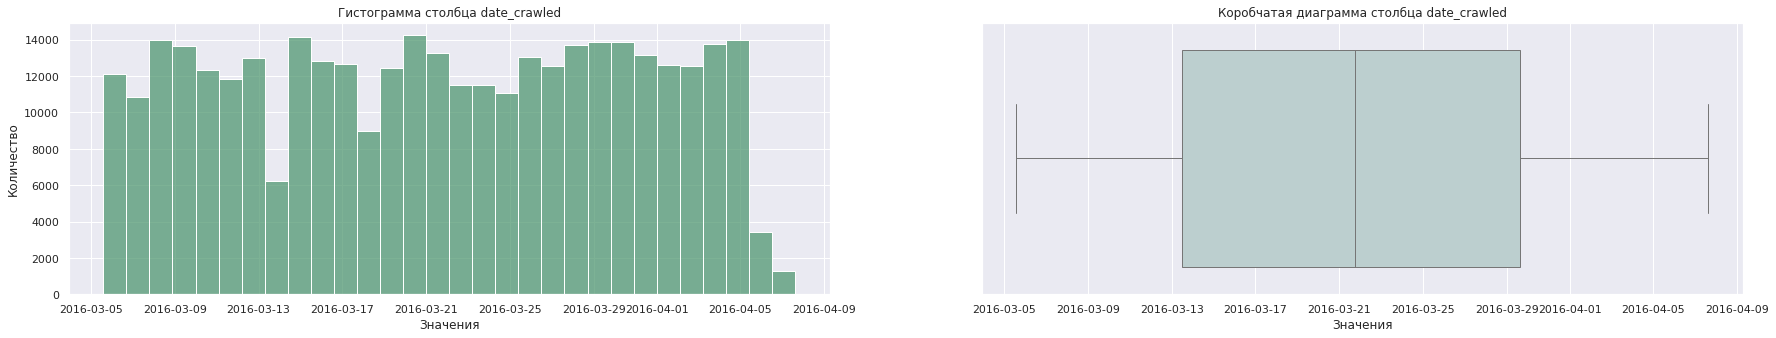

In [26]:
plot_graphics(autos, 'date_crawled', figsize=(30, 5))

## Анализ столбца `vehicle_type`

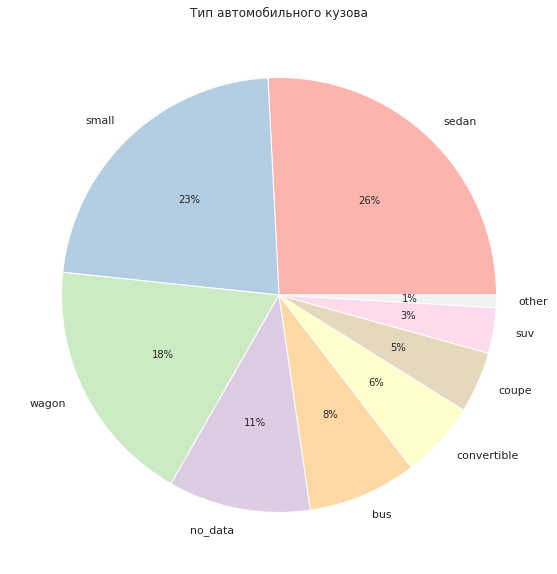

In [27]:
(autos
 .vehicle_type
 .value_counts()
 .plot(figsize=(10, 10), 
       title='Тип автомобильного кузова', 
       kind='pie', 
       colormap='Pastel1',
       autopct = "%.0f%%",
       ylabel= ""));

- Самая многичесленная группа - машины с кузовом sedan
- Самая малочисленная - other и suv
- Отметим, что около 11% данных в этом столбце пропущено

## Анализ столбца `registration_year`

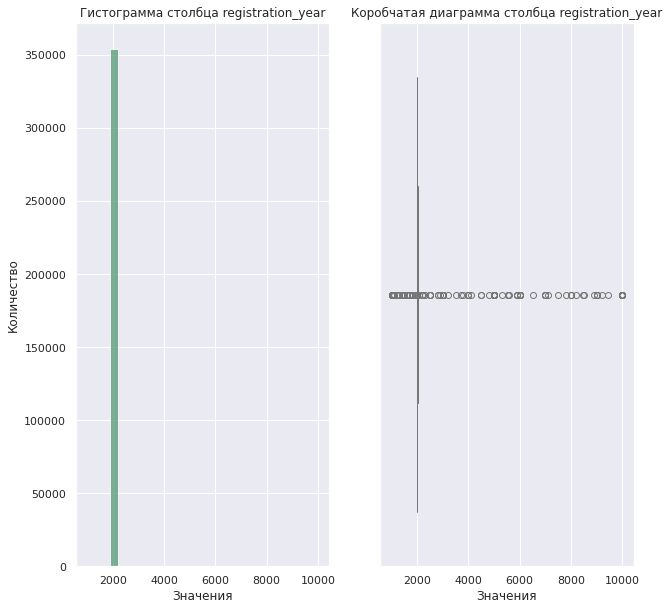

In [28]:
plot_graphics(autos, 'registration_year')

- Видим огромное количество выбросов, в основном справа. Попробуем ограничить признак слева квантилем 0.025, справа - 2016 годом

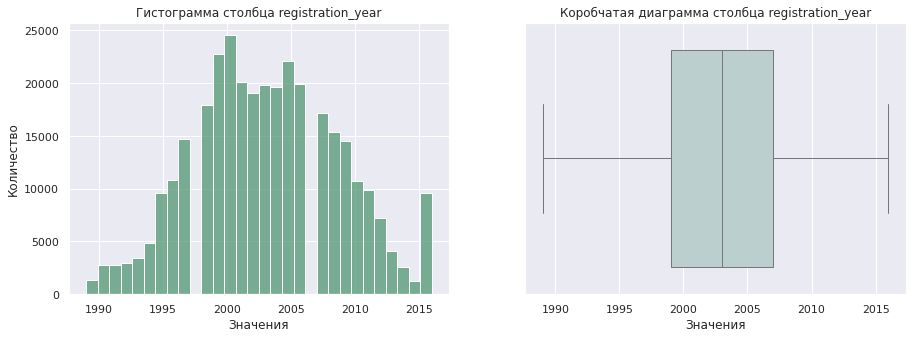

In [29]:
q_left = autos.registration_year.quantile(.025)
q_right = autos.registration_year.quantile(.975)
plot_graphics(autos.query("@q_left <= registration_year <= 2016"), 'registration_year', figsize=(15, 5))

In [30]:
retro_autos = autos.query("1900 < registration_year < 1989")

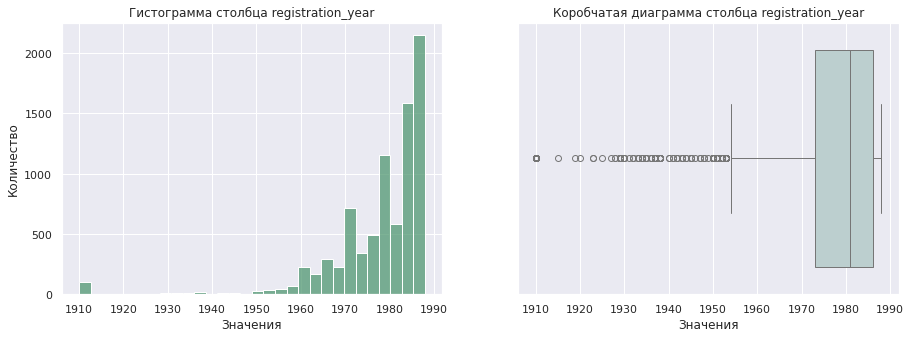

In [31]:
plot_graphics(retro_autos, 'registration_year', figsize=(15, 5))

In [32]:
retro_autos.sort_values('registration_year').head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
333004,2016-03-20 14:57:29,0,suv,1910,manual,0,no_data,5000,0,no_data,toyota,no_data,2016-03-20,0,48683,2016-03-20 14:57:29
193266,2016-03-13 12:46:46,0,no_data,1910,no_data,0,no_data,5000,0,petrol,sonstige_autos,no_data,2016-03-13,0,1454,2016-03-13 12:46:46
90011,2016-04-03 09:02:20,5000,no_data,1910,no_data,0,no_data,150000,0,petrol,bmw,no_data,2016-04-03,0,21079,2016-04-07 10:45:39
279596,2016-03-24 20:52:53,2500,no_data,1910,no_data,60,no_data,5000,0,petrol,peugeot,no_data,2016-03-24,0,1279,2016-04-05 13:47:07
343083,2016-04-01 08:51:08,1,other,1910,no_data,0,no_data,5000,1,other,volkswagen,no_data,2016-04-01,0,18273,2016-04-07 05:44:39


здесь явно данные с ошибками, так как volkswagen, например, начал выпускать свои машины в 1937 году

In [33]:
autos = autos.query("@q_left <= registration_year <= 2016")

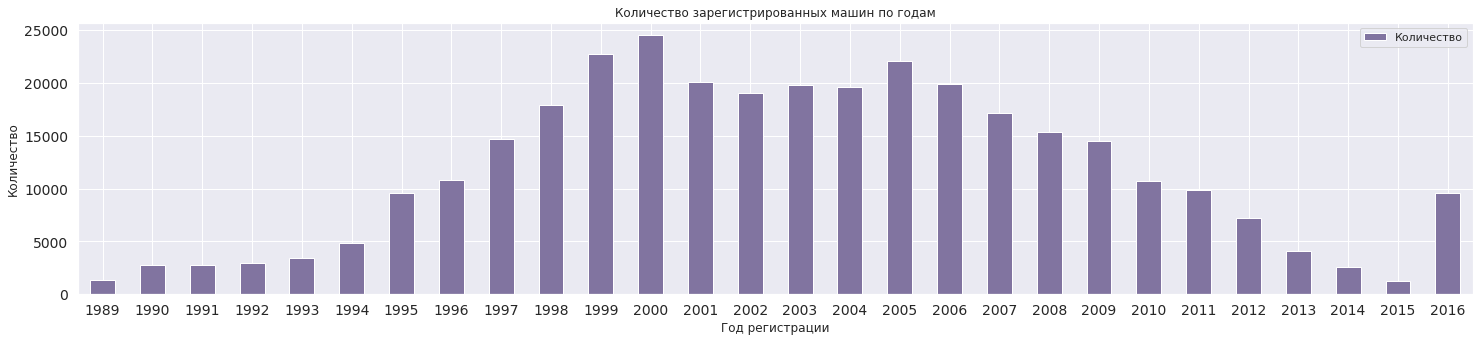

In [34]:
(autos
 .pivot_table(index='registration_year', 
              values='price', 
              aggfunc='count')
 .sort_index()
 .set_axis(['Количество'], axis=1)
 .plot(kind='bar', 
       figsize=(25, 5), 
       fontsize=14, 
       title='Количество зарегистрированных машин по годам', 
       ylabel='Количество', 
       color=DEFAULT_COLOR,
       xlabel='Год регистрации'))
plt.xticks(rotation=0);

- Больше всех автомобилей было зарегистрировано в 2000 году
- Меньше всех в 2015 году

In [35]:
(autos
 .pivot_table(index='registration_year', 
              values='gearbox', 
              aggfunc=pd.Series.mode))

,gearbox
registration_year,
1989,manual
1990,manual
1991,manual
1992,manual
1993,manual
1994,manual
1995,manual
1996,manual
1997,manual


- Довольно очевидны, что самым популярным видом коробки передач является - ручная

## Анализ столбца `gearbox` 

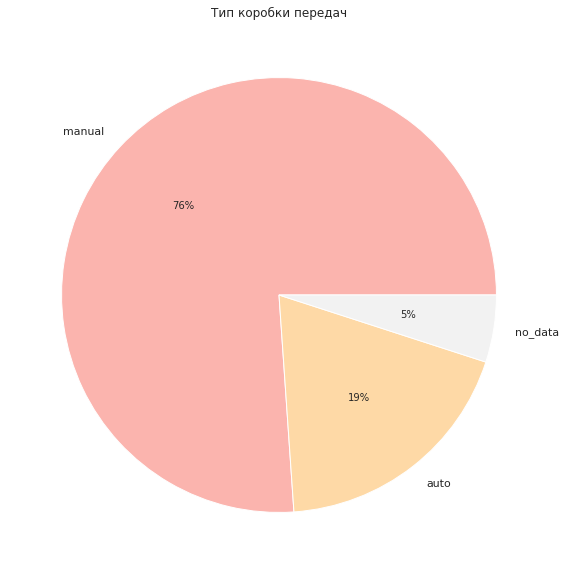

In [36]:
(autos
 .gearbox
 .value_counts()
 .plot(figsize=(10, 10), 
       title='Тип коробки передач', 
       kind='pie', 
       colormap='Pastel1',
       autopct = "%.0f%%",
       ylabel= ""));

- Самым популярным типом является ручная коробка передач
- Около 5 процентов данных в этом столбце - пропуски

## Анализ столбца `fuel_type` 

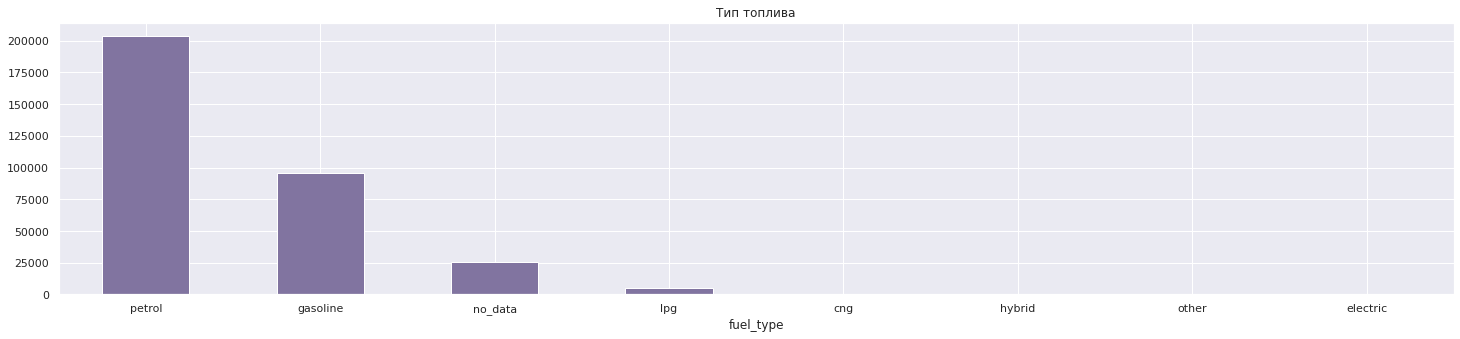

In [37]:
(autos
 .fuel_type
 .value_counts()
 .plot(figsize=(25, 5), 
       title='Тип топлива', 
       kind='bar', 
       color=DEFAULT_COLOR,
       ylabel= ""));

plt.xticks(rotation=0);

- Больше всего автомобилей с типом топлива petrol
- С пропусками в данном столбце около 25000 автомобилей

## Анализ столбца `repaired` 

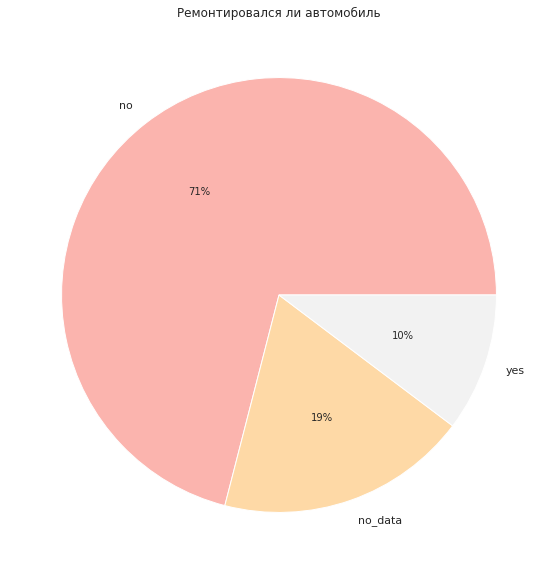

In [38]:
(autos
 .repaired
 .value_counts()
 .plot(figsize=(10, 10), 
       title='Ремонтировался ли автомобиль', 
       kind='pie', 
       colormap='Pastel1',
       autopct = "%.0f%%",
       ylabel= ""));

- Итак, видим, что большинство автомобилей в данных не ремонтировались
- Около 20 процентов с пропусками в этом столбце

## Анализ столбца `brand` 

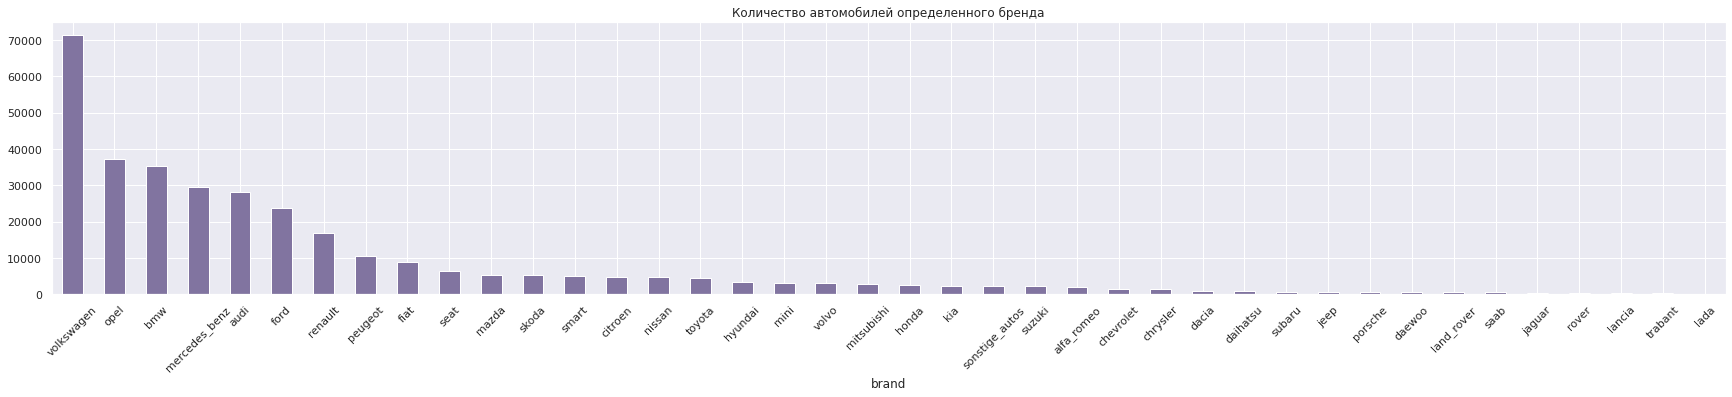

In [39]:
(autos
 .brand
 .value_counts()
 .plot(figsize=(30, 5), 
       title='Количество автомобилей определенного бренда', 
       kind='bar', 
       color=DEFAULT_COLOR,
       ylabel= ""));

plt.xticks(rotation=45);

- Самый популярный бренд - volkswagen
- Наименее популярный бренд машин - lada

In [40]:
autos.query("brand == 'volkswagen' or brand == 'lada'").pivot_table(
    index=['brand', 'model'],
    values='price',
    aggfunc='count'
)

price
brand      model             
lada       kalina           6
           niva           126
           no_data          9
           other           25
           samara          12
volkswagen amarok          15
           beetle         775
           bora           848
           caddy         1467
           cc             131
           eos            506
           fox            717
           golf         27005
           jetta          305
           kaefer          43
           lupo          2464
           no_data       2976
           other          590
           passat        9781
           phaeton        208
           polo         12351
           scirocco       541
           sharan        1405
           tiguan         650
           touareg        572
           touran        3261
           transporter   4317
           up             341

- Распределение моделей по самому популярному и наименее популярному бренду показывает, что
    - Volkswagen наиболее популярен в модели golf, меньше всего моделей типа amarok
    - У лады самая популярная модель - нива, меньше всего машин модели - калина

In [41]:
top10 = autos.brand.value_counts().index[:10]

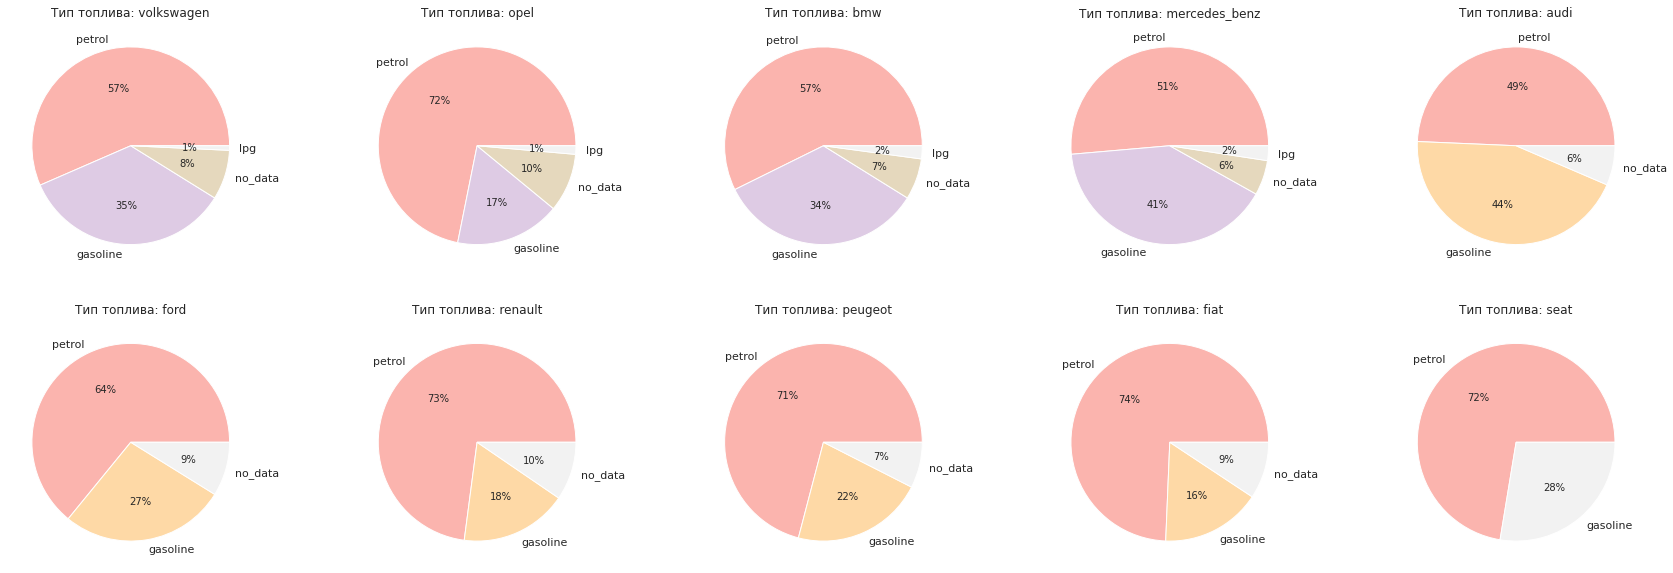

In [42]:
fig, ax = plt.subplots(2, 5, figsize=(30, 10))
ax = ax.flatten()

for idx, a in enumerate(ax):
    temp = autos.query(f'brand == "{top10[idx]}"').fuel_type.value_counts()
    (temp[temp > 500]
 .plot(
       title=f'Тип топлива: {top10[idx]}', 
       kind='pie', 
       colormap='Pastel1',
       autopct = "%.0f%%",
       ax=a,
       ylabel= ""));
    

- Видим, что 10 самых популярных марок машин в основном используют топливо petrol, хотя audi, например, имеет максимальный среди других процент использования топлива типа gasoline  

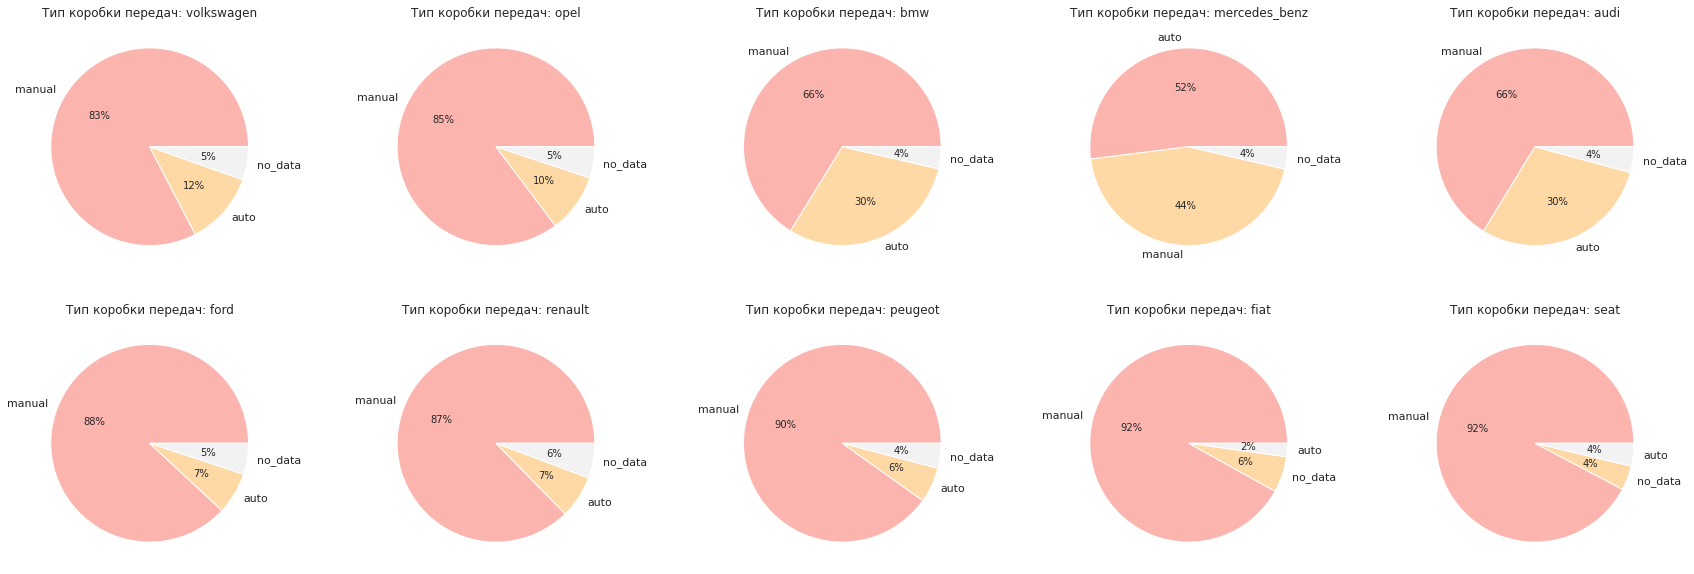

In [43]:
fig, ax = plt.subplots(2, 5, figsize=(30, 10))
ax = ax.flatten()

for idx, a in enumerate(ax):
    temp = autos.query(f'brand == "{top10[idx]}"').gearbox.value_counts()
    (temp
 .plot(
       title=f'Тип коробки передач: {top10[idx]}', 
       kind='pie', 
       colormap='Pastel1',
       autopct = "%.0f%%",
       ax=a,
       ylabel= ""));
    

- У самых популярных марок машин в основном ручная коробка передач
- Однако у машин марки Mercedes Benz гораздо чаще встречается автоматическая коробка передач 

## Анализ столбца `model`

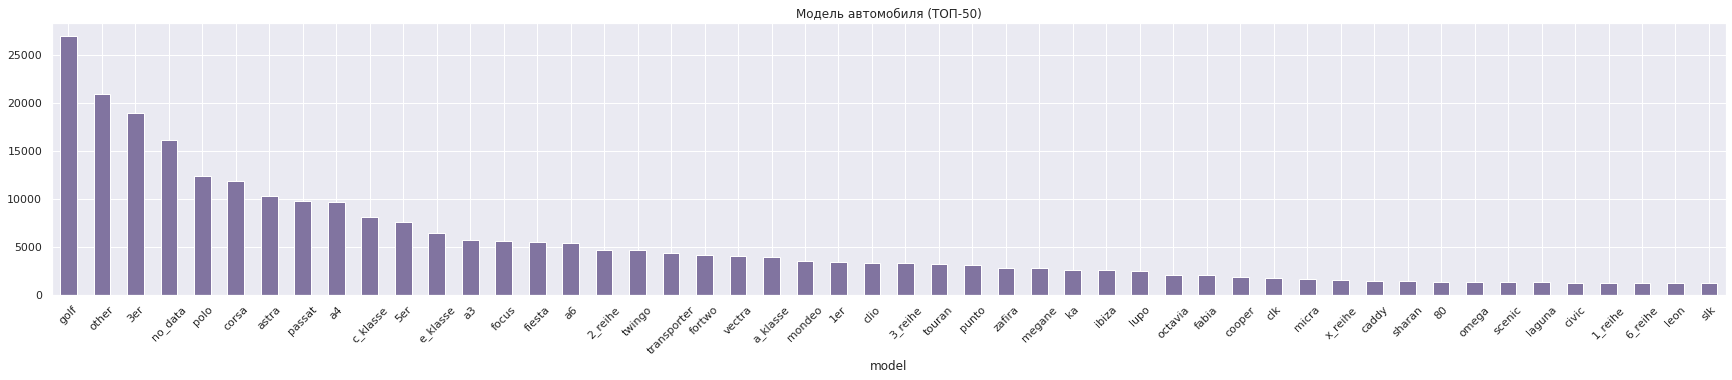

In [44]:
top50_models = autos.model.value_counts().index[:50]
(autos.query("model in @top50_models")
 .model
 .value_counts()
 .plot(figsize=(30, 5), 
       title='Модель автомобиля (ТОП-50)', 
       kind='bar', 
       color=DEFAULT_COLOR,
       ylabel= ""));

plt.xticks(rotation=45);

- Самая популярная модель машин - golf
- Наименее популярна модель - slk

## Анализ столбца `registration_month`

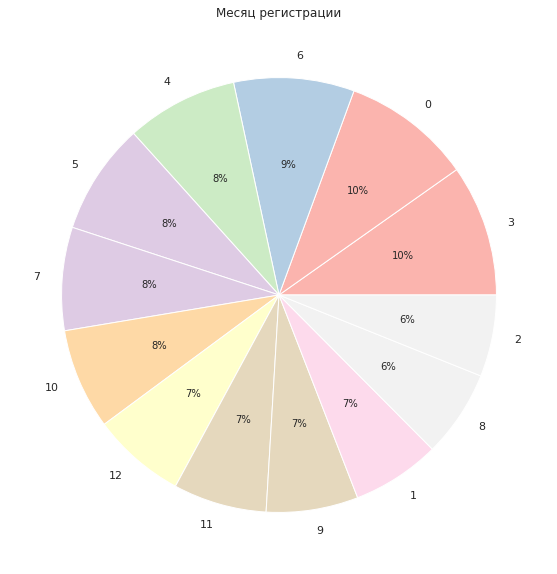

In [45]:
(autos
 .registration_month
 .value_counts()
 .plot(figsize=(10, 10), 
       title='Месяц регистрации', 
       kind='pie', 
       colormap='Pastel1',
       autopct = "%.0f%%",
       ylabel= ""));

Видим подорзрительное значение - нулевой месяц. Его тут явно не должно быть. Придется эти данные заменить

In [ ]:
autos.loc[autos.registration_month == 0, 'registration_month'] = 'no_data'

## Анализ столбца `date_created`

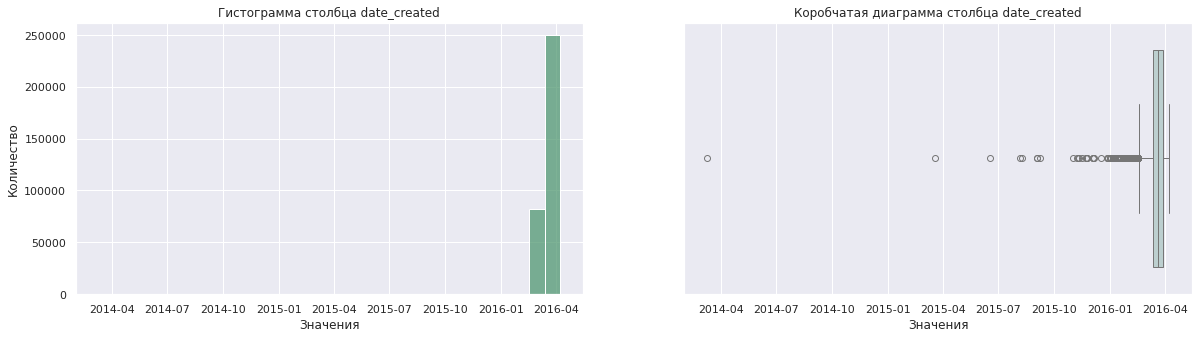

In [47]:
plot_graphics(autos, 'date_created', figsize=(20, 5))

In [48]:
autos = autos.query('date_created >= "2016-02"')

- В основном все анкеты созданы в марте-апреле 2016 года
- Есть выбросы слева
- Необходимо проверить, влияет ли этот признак на таргет, если нет, то удалим его

## Анализ столбца `last_seen`

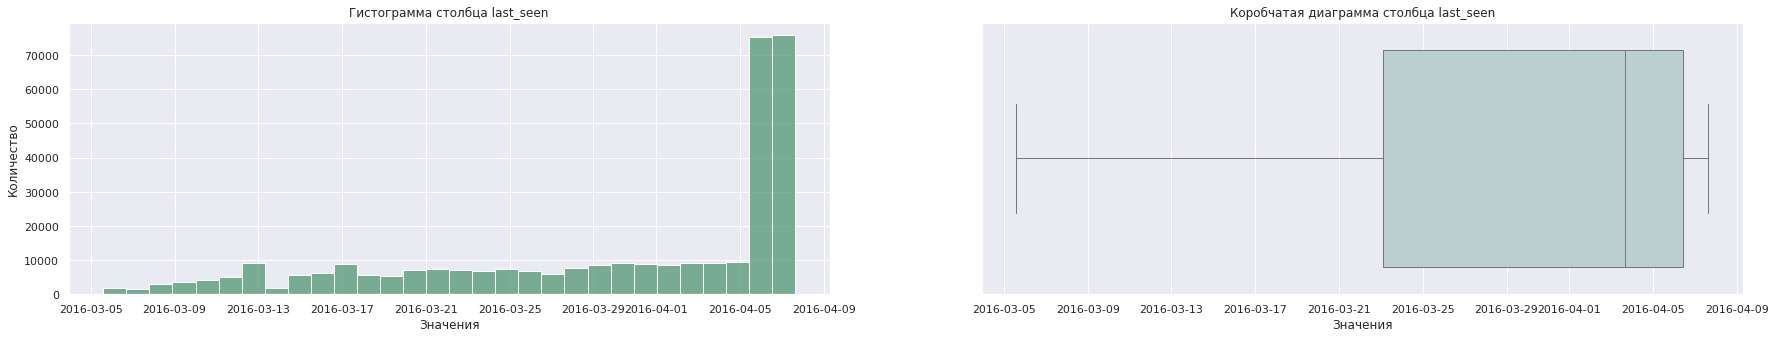

In [49]:
plot_graphics(autos, 'last_seen', figsize=(30, 5))

- Видим, что пик активности приходится на период с 5 по 9 апреля 2016 года

## Анализ столбца `power`

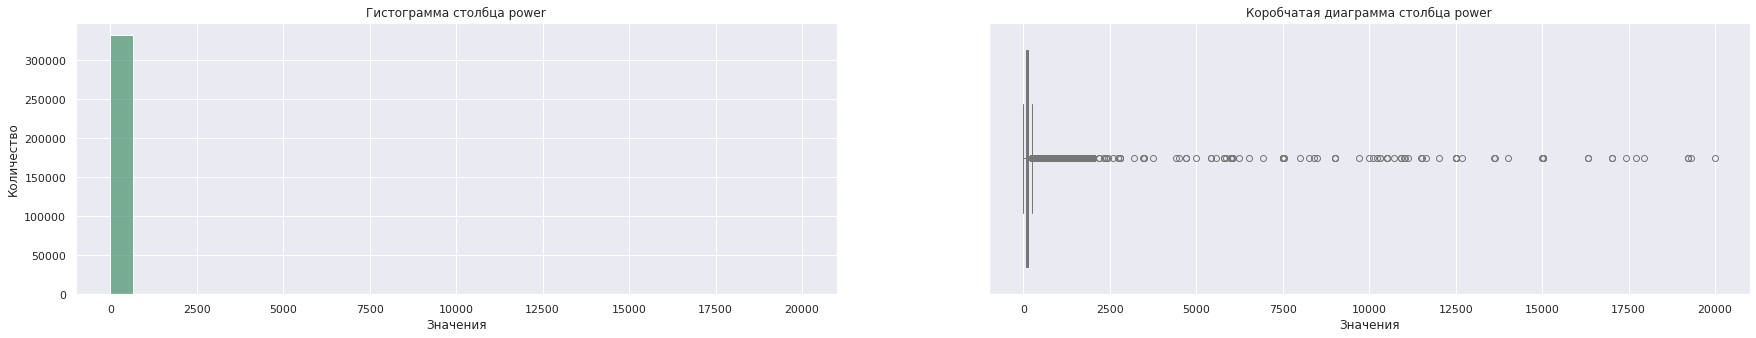

In [50]:
plot_graphics(autos, 'power', figsize=(30, 5))

- Видно, что есть выбросы в области высоких мощностей. Ограничим признак квантилями 0.025 и 0.975

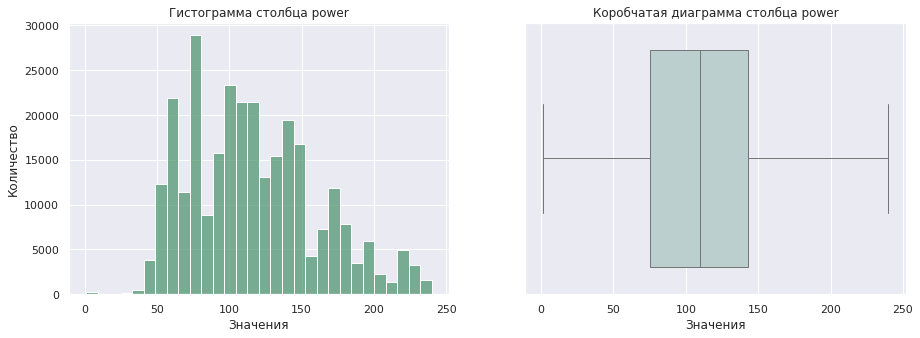

In [51]:
q975 = autos.power.quantile(.975)
q025 = autos.power.quantile(.025)
autos = autos.query('@q025 < power < @q975')

plot_graphics(autos, 'power', figsize=(15, 5))

In [53]:
autos.loc[autos['power'] <= 20, 'power'] = np.nan

autos.loc[autos.power.isna(), 'power'] = autos.groupby('vehicle_type')['power'].transform(
    lambda x: x.median() if x.median() is not None
    else autos['power'].median()
)

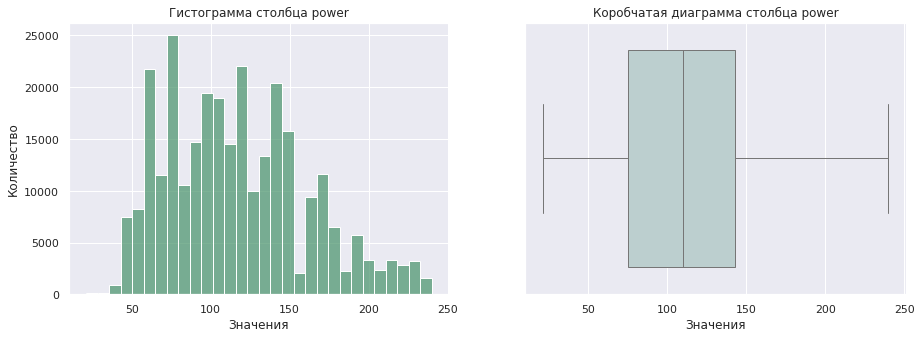

In [54]:
plot_graphics(autos, 'power', figsize=(15, 5))

## Анализ столбца `kilometer`

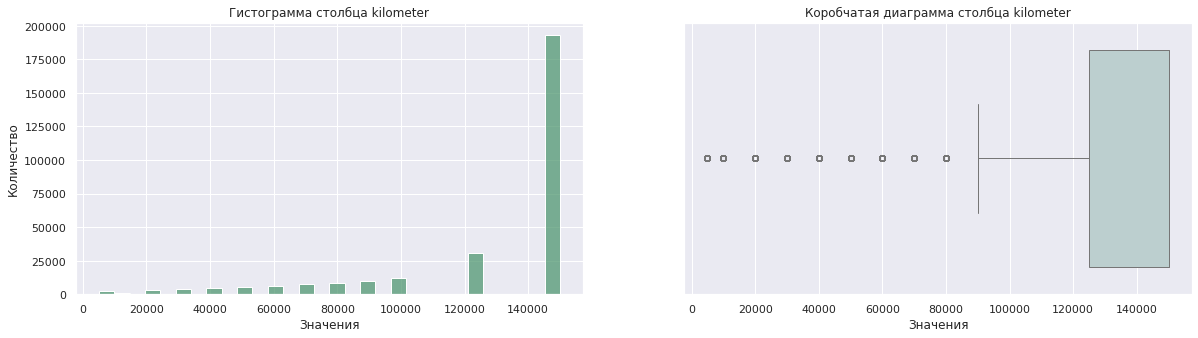

In [56]:
plot_graphics(autos, 'kilometer', figsize=(20, 5))

- Большинство машин имеют большой пробег

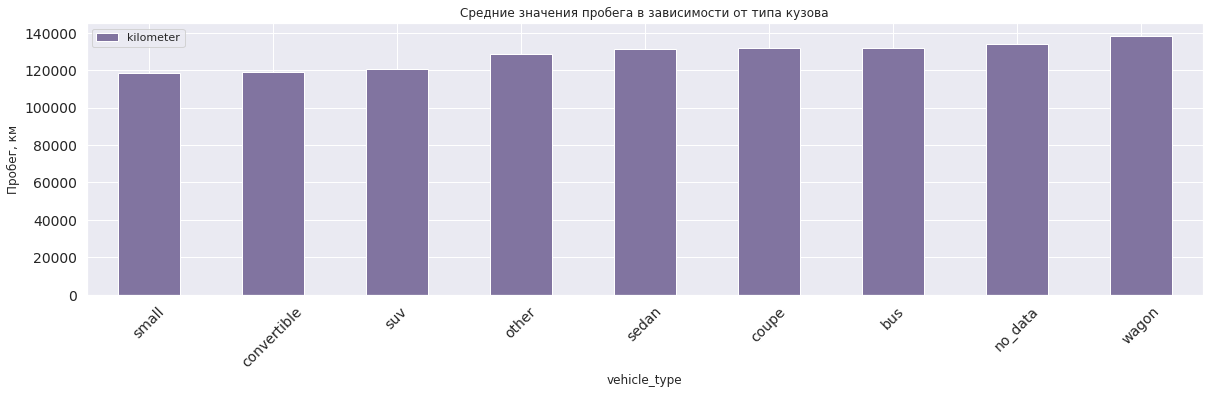

In [57]:
(autos
 .pivot_table(index='vehicle_type', 
              values='kilometer', 
              aggfunc='mean')
 .sort_values('kilometer')
 .plot(kind='bar', 
       figsize=(20, 5), 
       fontsize=14, 
       title='Cредние значения пробега в зависимости от типа кузова', 
       color=DEFAULT_COLOR,
       ylabel='Пробег, км'))
plt.xticks(rotation=45);

- Пробег в среднем больше у машин с типом кузова wagon
- Меньше всего у автомобилей с типом кузова convertible и small

## Анализ столбца `NumberOfPictures`

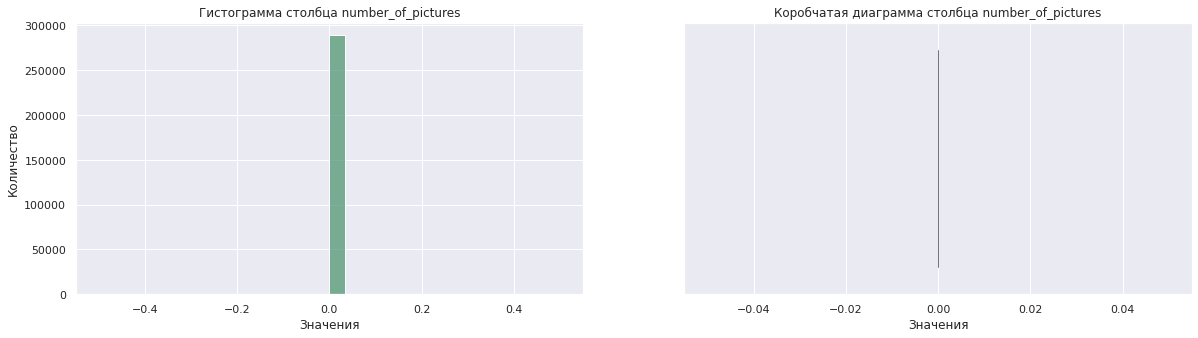

In [58]:
plot_graphics(autos, 'number_of_pictures', figsize=(20, 5))

- Абсолютно бесполезный (константный) столбец, его следует удалить

In [59]:
autos = autos.drop(columns='number_of_pictures')

## Анализ столбца `postal_code`

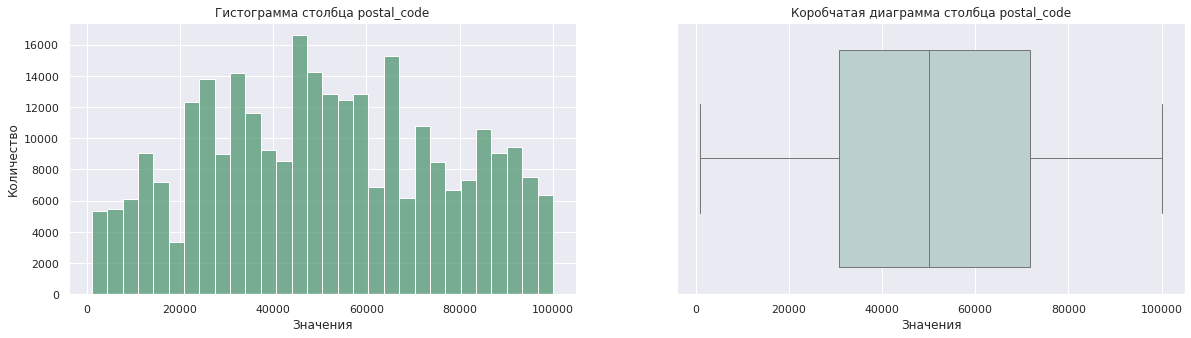

In [60]:
plot_graphics(autos, 'postal_code', figsize=(20, 5))

- Есть определенные сомнения, что этот признак будет влиять на таргет, проверим это в ходе корреляционного анализа

## Анализ столбца `price`

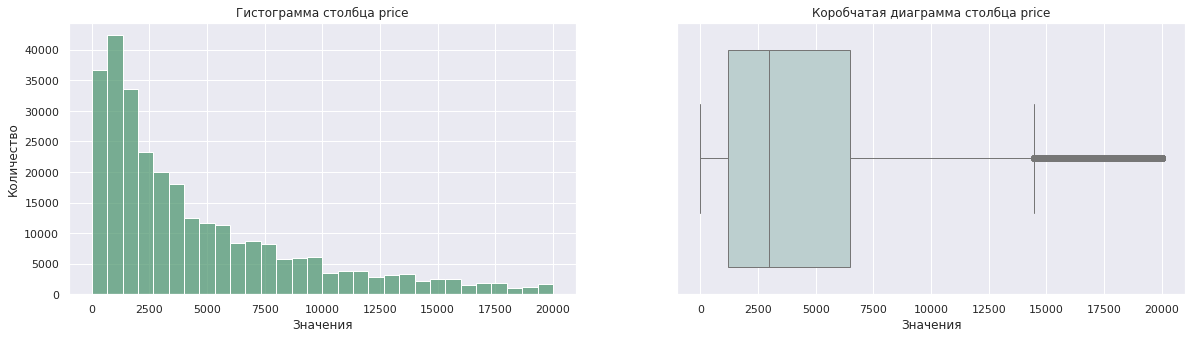

In [61]:
plot_graphics(autos, 'price', figsize=(20, 5))

- Распределение похоже на лог-нормальное
- Справа на коробчатой диаграмме видны выбросы - дорогие машины

In [62]:
def median_price_by(col, title, ylabel='Медианная стоимость, евро', xlabel=None, figsize=(20, 5), rotation=0, df=None):
    label_maker = lambda t: col if t is None else xlabel
    if df is None:
        (autos
 .pivot_table(index=col, 
              values='price', 
              aggfunc='median')
 .sort_values('price')
 .plot(kind='bar', 
       figsize=figsize, 
       fontsize=14, 
       title=title,
       color=DEFAULT_COLOR,
       ylabel=ylabel,
       xlabel=label_maker(xlabel)))
        plt.xticks(rotation=rotation);
    else:
        (df
 .sort_values('price')
 .plot(kind='bar', 
       figsize=figsize, 
       fontsize=14, 
       title=title,
       color=DEFAULT_COLOR,
       ylabel=ylabel,
       xlabel=label_maker(xlabel)))
        plt.xticks(rotation=rotation);
    

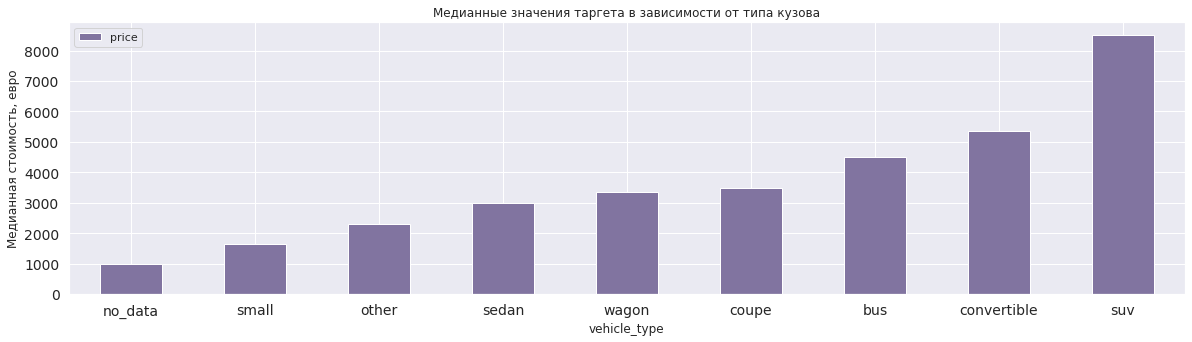

In [63]:
median_price_by('vehicle_type', 'Медианные значения таргета в зависимости от типа кузова')

- В среднем самыми дорогими машинами являются автомобили с типом кузова suv
- А вот самымим дешевыми в среднем являются автомобили с кузовом small или те, машины, где есть пропуск в этом столбце

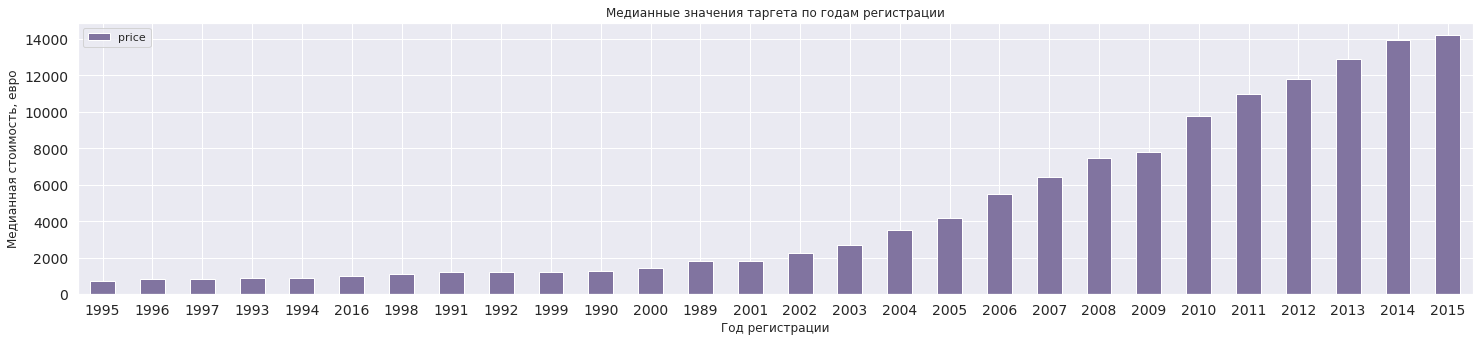

In [64]:
median_price_by('registration_year', 'Медианные значения таргета по годам регистрации', xlabel='Год регистрации', figsize=(25, 5))

- Видим, что в среднем самые дорогие машины были зарегистрированы в 2015 года
- Самые дешевые - в 1995
- Кроме того, вплоть до 2015 года видна четкая тенденция на рост медианной стоимости автомобиля

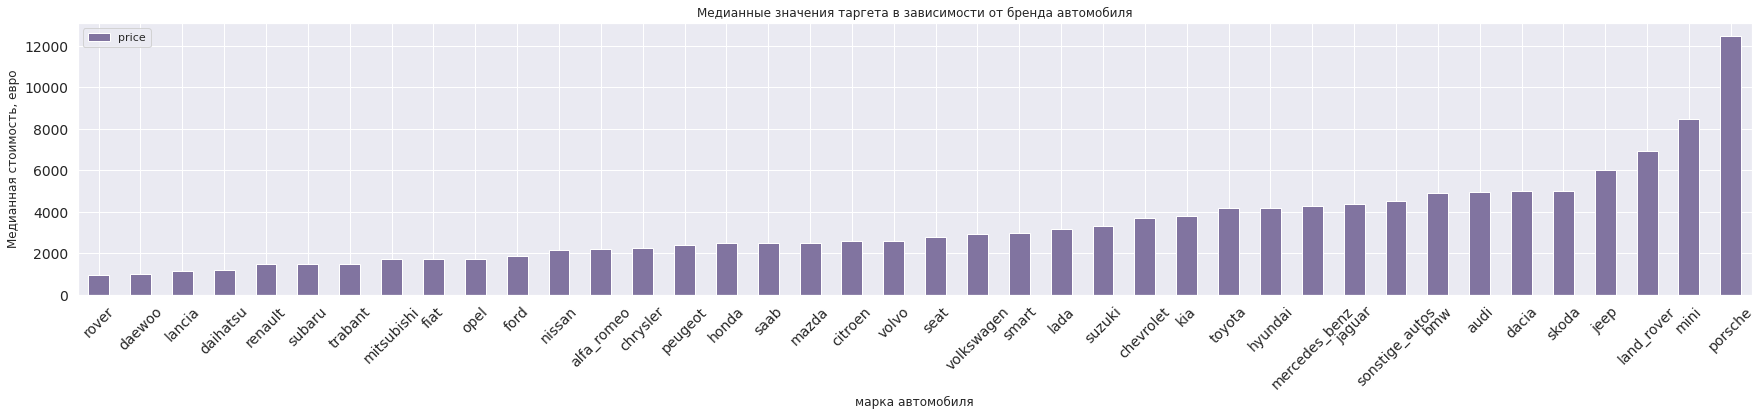

In [65]:
median_price_by('brand', 'Медианные значения таргета в зависимости от бренда автомобиля', xlabel='марка автомобиля', figsize=(30, 5), rotation=45)

- В среднем самыми дорогими являются автомобили марки porsche
- А самыми дешевыми марки rover

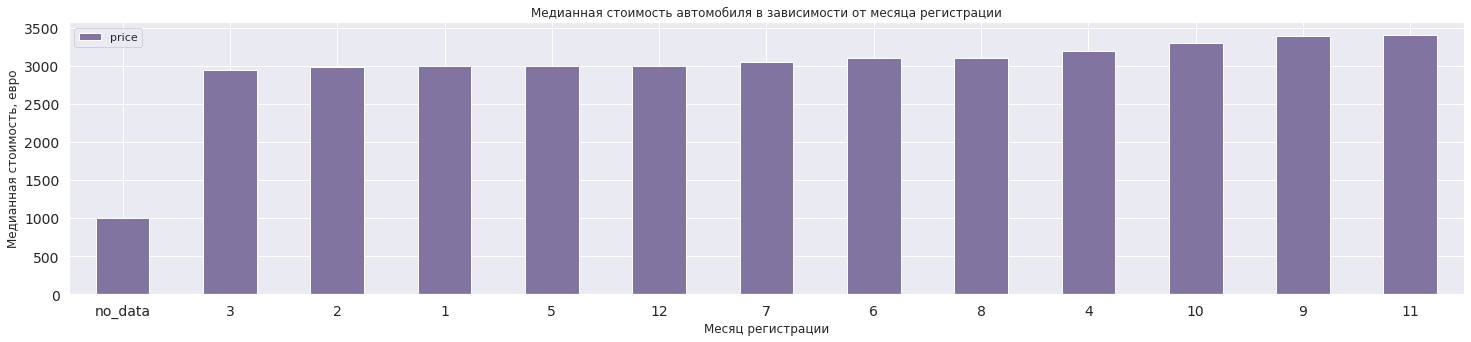

In [66]:
median_price_by('registration_month', 'Медианная стоимость автомобиля в зависимости от месяца регистрации', xlabel='Месяц регистрации', figsize=(25, 5))

- Видим, что в среднем цена остается приблизительно одинаковой в любой из месяцев, несколько отличаются средней стоимостью автомобили, зарегистрированные осенью

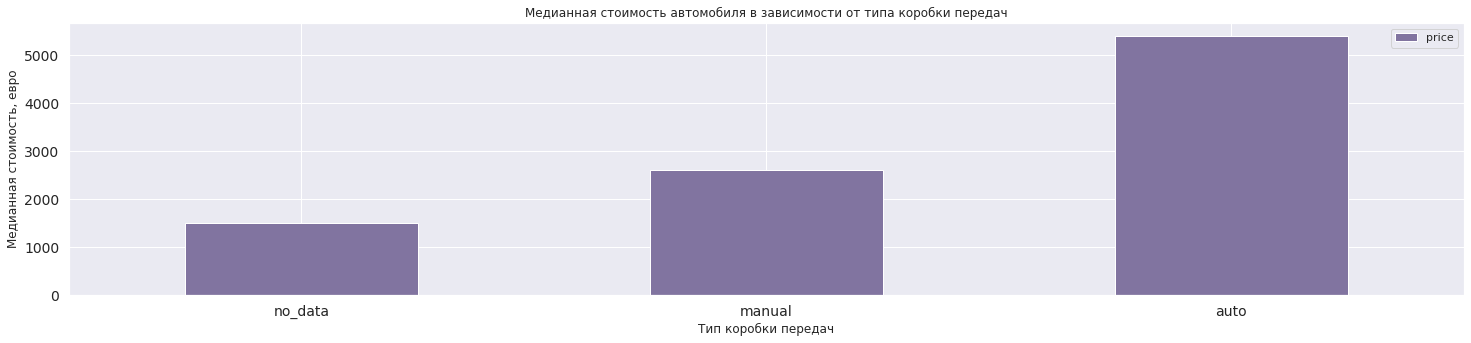

In [67]:
median_price_by('gearbox', 'Медианная стоимость автомобиля в зависимости от типа коробки передач', xlabel='Тип коробки передач', figsize=(25, 5))

- Видим, что цена автомобилей с автоматической коробкой передач в среднем более чем в два раза дороже машин с ручной коробкой

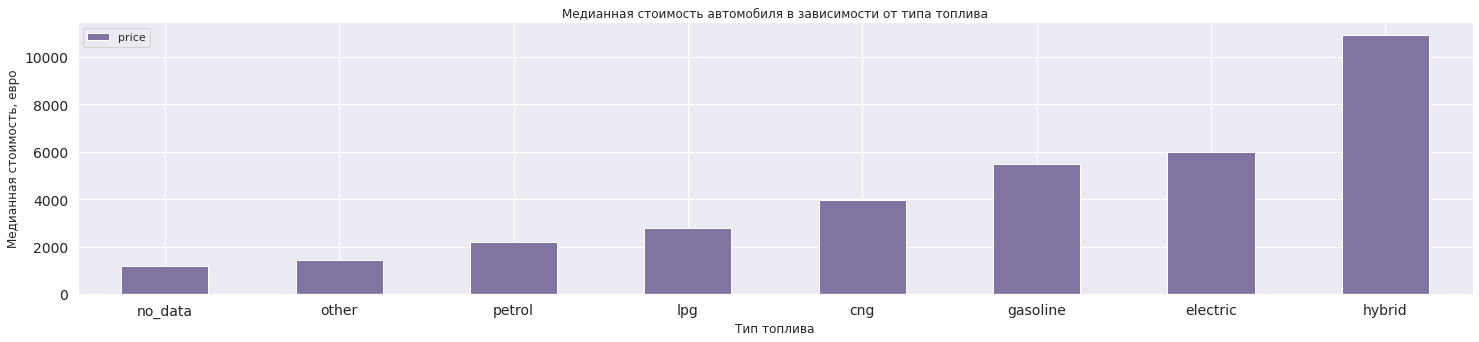

In [68]:
median_price_by('fuel_type', 'Медианная стоимость автомобиля в зависимости от типа топлива', xlabel='Тип топлива', figsize=(25, 5))

- Исходя из известных видов топлива можно сделать следующие выводы: 
    - В среднем машины, работающие на топливе типа petrol дешевле всего
    - Рвботающие на гибридном, электрическом и gasoline - дороже всего

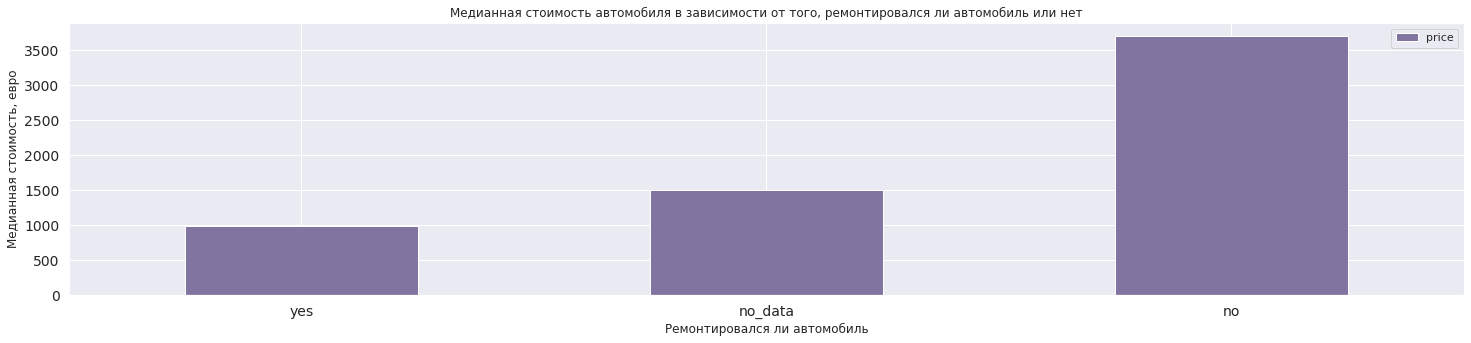

In [69]:
median_price_by('repaired', 'Медианная стоимость автомобиля в зависимости от того, ремонтировался ли автомобиль или нет', xlabel='Ремонтировался ли автомобиль', figsize=(25, 5))

- Машины, которые не были в ремонте, однозначно стоят в среднем дороже, чем отремонтированные автомобили, причем в более чем в три раза

In [70]:
top10_models_highest = (autos
 .pivot_table(index='model', 
              values='price', 
              aggfunc='median')
 .sort_values('price', ascending=False))[:10]

top10_models_lowest = (autos
 .pivot_table(index='model', 
              values='price', 
              aggfunc='median')
 .sort_values('price', ascending=True))[:10]

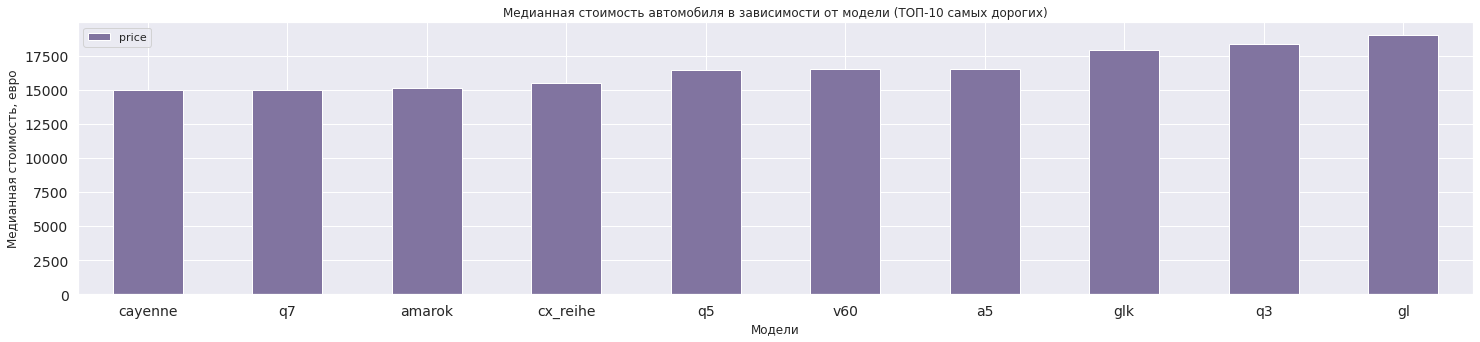

In [71]:
median_price_by('model', 'Медианная стоимость автомобиля в зависимости от модели (ТОП-10 самых дорогих)', xlabel='Модели', figsize=(25, 5), df=top10_models_highest)

In [72]:
autos[autos.model.isin(top10_models_highest.index)].brand.unique()

array(['audi', 'mazda', 'mercedes_benz', 'volvo', 'volkswagen', 'porsche'],
      dtype=object)

- Среди в среднем самых дорогих значатся машины марок `audi, mazda, mercedes_benz, volvo, volkswagen, porsche`

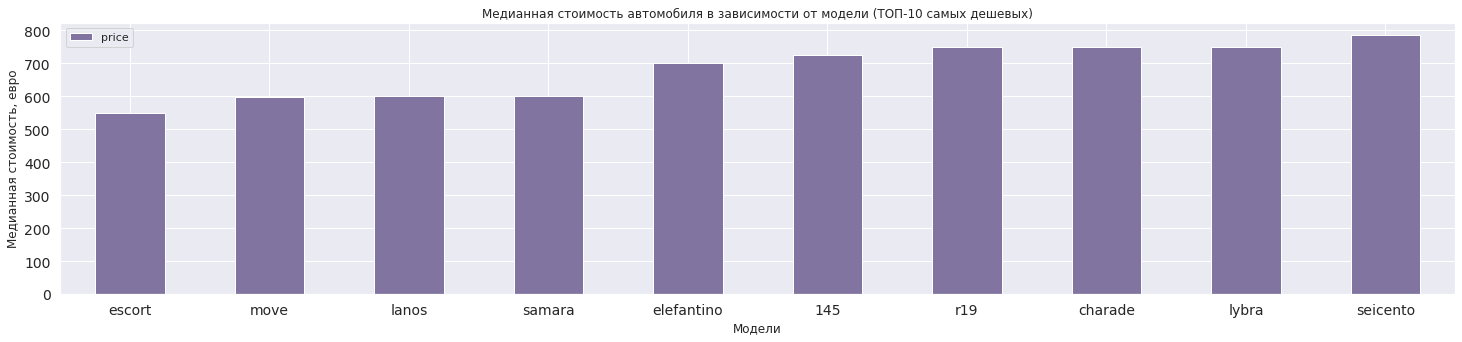

In [73]:
median_price_by('model', 'Медианная стоимость автомобиля в зависимости от модели (ТОП-10 самых дешевых)', xlabel='Модели', figsize=(25, 5), df=top10_models_lowest)

In [74]:
autos[autos.model.isin(top10_models_lowest.index)].brand.unique()

array(['ford', 'renault', 'daewoo', 'fiat', 'lancia', 'daihatsu',
       'alfa_romeo', 'lada'], dtype=object)

- Среди в среднем самых бюджетных значатся машины марок `ford, renault, mitsubishi, fiat, lancia, daewoo, daihatsu, alfa_romeo`

1. **Данные**  
   - Много пропусков: `vehicle_type` (11%), `gearbox` (5%), `fuel_type` (~25 тыс.), `repaired` (20%).  
   - Выбросы: в `registration_year`, `power`, `month_of_registration` (нулевые значения — ошибка).  

2. **Категориальные признаки**  
   - Популярные:  
     - Кузов: `sedan` (чаще), `suv` (дороже).  
     - КПП: ручная (дешевле), автоматическая (в 2 раза дороже).  
     - Топливо: `petrol` (чаще), `hybrid/electric` (дороже).  
   - Бренды:  
     - Дорогие: Porsche, Audi, Mercedes.  
     - Дешевые: Lada, Rover, Daewoo.  

3. **Числовые признаки**  
   - `registration_year`:  
     - Пик — 2000 год, минимум — 2015.  
     - Машины до 2015 дорожали с каждым годом.  
   - `power`:  
     - Высокие значения потребовали обработки (ограничили значения квантилем справа, а низкие заполнили медианой по типу кузова).  

4. **Цена (таргет)**  
   - Дороже: SUV, автоматическая КПП, гибрид, неремонтированные, премиальные бренды.  
   - Дешевле: малые кузова, ручная КПП, бензин, отремонтированные, бюджетные марки (но не всегда, alpha romeo явно не самая бюджетная марка).  

# Корреляционный анализ

In [75]:
temp = autos.copy()

temp['date_crawled_day'] = temp['date_crawled'].dt.day
temp['date_crawled_month'] = temp['date_crawled'].dt.month

temp['last_seen_day'] = temp['last_seen'].dt.day
temp['last_seen_month'] = temp['last_seen'].dt.month

temp['date_created_day'] = temp['date_created'].dt.day
temp['date_created_month'] = temp['date_created'].dt.month

temp = temp.drop(columns=['date_crawled', 'last_seen', 'date_created'])


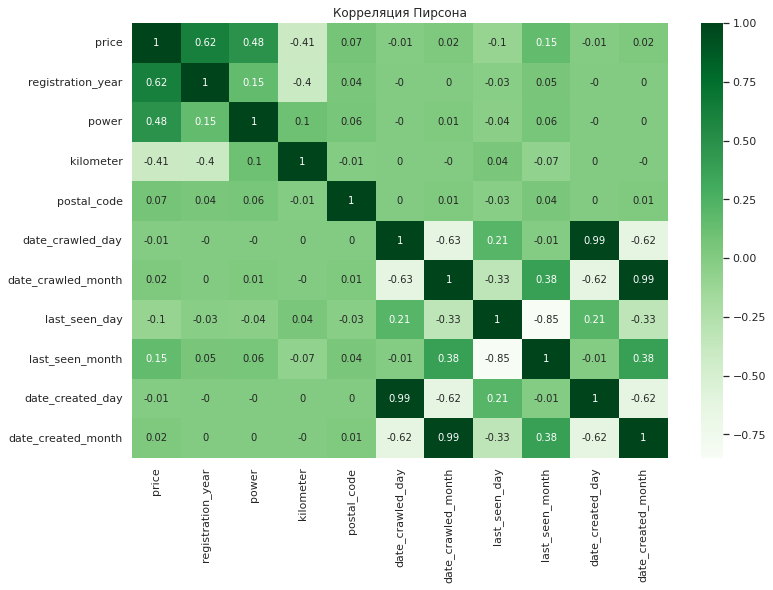

In [76]:
plt.figure(figsize=(12, 8))
sns.heatmap(temp.select_dtypes(['int', 'int64', 'int32', 'float', 'double']).corr().round(2), annot=True, cmap='Greens')
plt.title('Корреляция Пирсона');

- Наибольшая линейная взаимосвязь у таргета с признаками registration_year, power и kilometer
- Меньше всего корреляция Пирсона между таргетом и признаками postal_code, date_created, registration_month и date_crawled

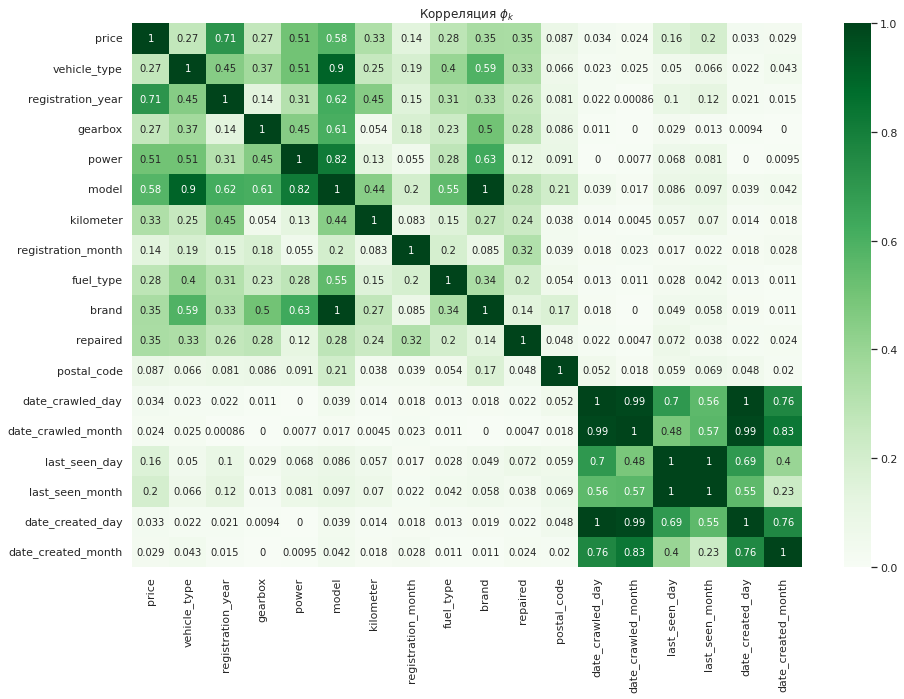

In [77]:
plt.figure(figsize=(15, 10))
numeric_cols = temp.select_dtypes(['int', 'int64', 'int32', 'float', 'double']).columns
sns.heatmap(phik.phik_matrix(temp, interval_cols=numeric_cols), annot=True, cmap='Greens')
plt.title('Корреляция $\phi_k$');

- Здесь видим подтверждение наличия связи между указанными выше признаками и таргетом, но здесь видна корреляция и с категориальными признаками
- Стопроцентная взаимосвязь между маркой и моделью может говорить об уникальности модели определенной марки. То есть все модели уникальны

Исходя из корреляционного анализа и причинно-следственных связей, будем удалять признаки `postal_code, date_created и date_crawled`, а также поле `brand`

# Обучение моделей

In [85]:
data = autos.drop(columns=['postal_code', 'brand', 'registration_month'], errors='ignore')

In [86]:
data['last_seen_day'] = data['last_seen'].dt.day
data['last_seen_month'] = data['last_seen'].dt.month

data = data.drop(columns=['date_crawled', 
                          'last_seen', 
                          'date_created'], errors='ignore')

In [87]:
data = data.drop_duplicates()

X = data.drop(columns='price')
y = data.price

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [89]:
categorical_cols = ['vehicle_type', 'gearbox', 'fuel_type', 'model', 'repaired']
num_columns = X_train.select_dtypes(['float64', 'int', 'int64']).columns

In [90]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
    )

In [91]:
data_preprocessor_linear = ColumnTransformer(
    [
     ('ohe', ohe_pipe, categorical_cols),
     ('num', StandardScaler(), num_columns),  
    ], 
    remainder='passthrough'
)

data_preprocessor_tree = ColumnTransformer(
    [
     ('ohe', ohe_pipe, categorical_cols),
    ], 
    remainder='passthrough'
)

pipe_final_lin = Pipeline([
    ('preprocessor', data_preprocessor_linear),
    ('models', DecisionTreeRegressor())
])

pipe_final_tree = Pipeline([
    ('preprocessor', data_preprocessor_tree),
    ('models', DecisionTreeRegressor())
])

pipe_final_boosting = Pipeline([
    ('models', DecisionTreeRegressor())
])

In [ ]:
param_grid_tree = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 12, 1),
        'models__max_features': range(2, 200, 1),
#         'preprocessor__num': ['passthrough']  
    }
]

regressor_tree = RandomizedSearchCV(
    pipe_final_tree, 
    param_grid_tree, 
    cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    error_score='raise',
)
warnings.filterwarnings("ignore", category=UserWarning)
regressor_tree.fit(X_train, y_train)

In [93]:
X_train_gbm = X_train.copy()
X_test_gbm = X_test.copy()

for col in categorical_cols:
    X_train_gbm[col] = X_train_gbm[col].astype('category')

for col in categorical_cols:
    X_test_gbm[col] = pd.Categorical(X_test_gbm[col], categories=X_train_gbm[col].cat.categories)

In [94]:
param_grid_lgbm = [
    {
        'models': [lgb.LGBMModel(objective="regression", n_estimators=10, n_jobs=-1, verbosity=-1, category=categorical_cols)],
        'models__n_estimators': [15, 100, 150],
    }
]

regressor_lgbm = RandomizedSearchCV(
    pipe_final_boosting, 
    param_grid_lgbm, 
    cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    error_score='raise',
)
warnings.filterwarnings("ignore", category=UserWarning)
regressor_lgbm.fit(X_train_gbm, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=Pipeline(steps=[('models',
                                              DecisionTreeRegressor())]),
                   param_distributions=[{'models': [LGBMModel(category=['vehicle_type',
                                                                        'gearbox',
                                                                        'fuel_type',
                                                                        'model',
                                                                        'repaired'],
                                                              n_estimators=10,
                                                              n_jobs=-1,
                                                              objective='regression',
                                                              verbosity=-1)],
                                         'models__n_estimators': [15, 100,
                                                                  150]}],
                   random_state=42, scoring='neg_root_mean_squared_error')

In [ ]:
param_grid_forest = [
    {
        'models': [RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)],
        'models__max_depth': [10],
        'models__n_estimators': [25],
        'models__max_features': [100, 150],
        
    }
]

regressor_forest = RandomizedSearchCV(
    pipe_final_tree, 
    param_grid_forest, 
    cv=5,
    scoring='neg_root_mean_squared_error',
    error_score='raise',
    verbose=10
)
warnings.filterwarnings("ignore", category=UserWarning)
regressor_forest.fit(X_train, y_train)

In [96]:
param_grid_ridge = [
    {
        'models': [Ridge()],
        'models__alpha': [0.001, 0.01, 0.1, 1],
        'preprocessor__num': [StandardScaler()]  
        
    }
]

regressor_ridge = RandomizedSearchCV(
    pipe_final_lin, 
    param_grid_ridge, 
    cv=5,
    scoring='neg_root_mean_squared_error',
    error_score='raise',
)
warnings.filterwarnings("ignore", category=UserWarning)
regressor_ridge.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['vehicle_type',
                                                                                'gearbox',
                                                                                'fuel_type',
                                                                                'model',
                                                                                'repaired']),
                                                                              ('num',
                                                                               StandardScaler(),
                                                                               Index(['registration_year', 'power', 'kilometer', 'last_seen_day',
       'last_seen_month'],
      dtype='object'))])),
                                             ('models',
                                              DecisionTreeRegressor())]),
                   param_distributions=[{'models': [Ridge()],
                                         'models__alpha': [0.001, 0.01, 0.1, 1],
                                         'preprocessor__num': [StandardScaler()]}],
                   scoring='neg_root_mean_squared_error')

In [97]:
pd.DataFrame({
    'CV RMSE': [(-1) * regressor_tree.best_score_, (-1) * regressor_forest.best_score_, (-1) * regressor_ridge.best_score_, (-1) * regressor_lgbm.best_score_],
    'fit time': [regressor_tree.cv_results_['mean_fit_time'][regressor_tree.best_index_], 
                 regressor_forest.cv_results_['mean_fit_time'][regressor_forest.best_index_], 
                 regressor_ridge.cv_results_['mean_fit_time'][regressor_ridge.best_index_], 
                 regressor_lgbm.cv_results_['mean_fit_time'][regressor_lgbm.best_index_]],
}, index=['Decision Tree Regressor', 'Random Forest', 'Ridge', 'LGBM']).round(2)

,CV RMSE,fit time
Decision Tree Regressor,1967.56,3.93
Random Forest,1807.56,44.86
Ridge,2300.47,2.55
LGBM,1524.85,1.88


- Видим, что на CV лучшей моделью оказался градиентный бустинг LGBM
- Хуже всего, что ожидаемо, показала себя линейная регрессия: зависимости оказались сложнее чем просто линейные
- Однако следует отметить, что все модели уложились в условие по метрике: $RMSE \leqslant 2500$

На кросс-валидации выбираем градентный бустинг как по времени, так и по значению метрики

In [107]:
best_model_regression = regressor_lgbm.best_estimator_.named_steps['models']

In [108]:
X = pd.DataFrame(data=X_test_gbm, columns=X_test_gbm.columns)

In [98]:
start_lgbm_predict = time.time()
preds = regressor_lgbm.best_estimator_.predict(X_train_gbm)
print(f'Время предсказания LGBM: {(time.time() - start_lgbm_predict):.4f}')

Время предсказания LGBM: 2.4275


In [99]:
start_forest_predict = time.time()
preds = regressor_forest.best_estimator_.predict(X_train)
print(f'Время предсказания RF: {(time.time() - start_forest_predict):.4f}')

Время предсказания RF: 1.9499


In [100]:
start_tree_predict = time.time()
preds = regressor_tree.best_estimator_.predict(X_train)
print(f'Время предсказания DT: {(time.time() - start_tree_predict):.4f}')

Время предсказания DT: 1.2821


In [101]:
start_ridge_predict = time.time()
preds = regressor_ridge.best_estimator_.predict(X_train)
print(f'Время предсказания Ridge: {(time.time() - start_ridge_predict):.4f}')

Время предсказания Ridge: 1.2048


- По времени предсказания лидирует линейная регрессия, а аутсайдером оказался его величество бустинг.
- Однако время обучения бустинга меньше времени обучения всех остальных моделей


На основании анализа производительности моделей, по большинству критериев выиграл бустинг
    - Самая низкая ошибка на CV
    - Самое короткое время обучения
    - Но предсказания делает медленнее коллег
    
Сделаем итоговую оценку качества на тестовых данных для бустинга

In [102]:
round(root_mean_squared_error(regressor_lgbm.best_estimator_.predict(X_test_gbm), y_test), 2)

1521.36

В условия проекта уложились

# Анализ остатков модели

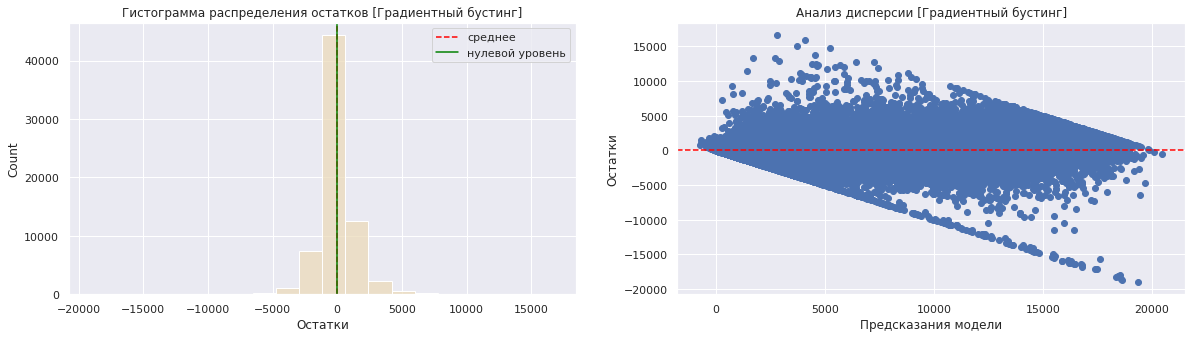

In [103]:
analyze_residuals(y_test - regressor_lgbm.best_estimator_.predict(X_test_gbm), regressor_lgbm.best_estimator_.predict(X_test_gbm), 'Градиентный бустинг')

- Среднее значение предсказаний практически совпадает с нулевым уровнем (модель занижает цену на 2.37 евро)
- Дисперсия остатков, по большей части, сгруппирована вокруг нулевого уровня и вытянута в параллелограмм, но наблюдается некоторая полоса от малых цен до высоких с уклоном в завышение цен. Однако влияние этой полосы, видимо, ограничено, так как средний уровень остатков все таки сосредосточен в малой окрестности нуля.
- Для недорогих машин модель определяет цену довольно однозначно, для самых дорогих, в целом, тоже.

In [105]:
(y_test - regressor_lgbm.best_estimator_.predict(X_test_gbm)).mean()

-2.365109818000005

# Анализ важности признаков

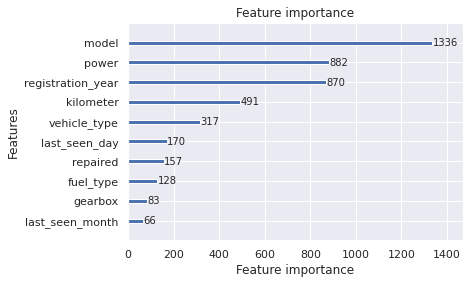

In [109]:
lgb.plot_importance(best_model_regression.booster_);

- Градиентный бустинг определил для себя самой важной характеристикой модель автомобиля, а такде год регистрации автомобиля и мощность
- Меньше всего влияет на предсказание признак - тип коробки передач

In [110]:
explainer = shap.TreeExplainer(best_model_regression.booster_)
shap_values = explainer(X) 

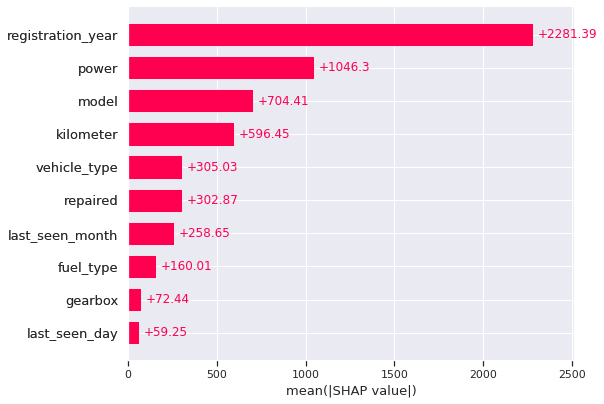

In [111]:
shap.plots.bar(shap_values)

- А вот SHAP-анализ показывает, что самыми важными признаками является год регистрации и мощность и уже только потом модель автомобиля
- В оценке наименее важного признака встроенная оценка важности и shap анализ солидарны. Это тип коробки передач

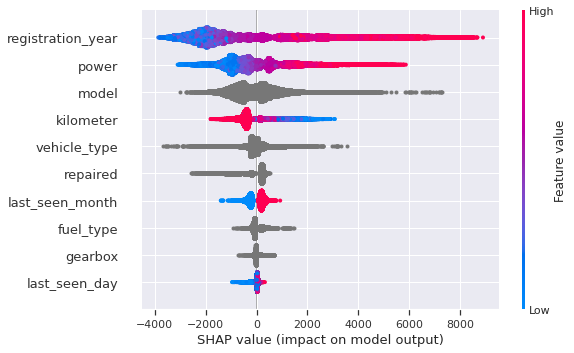

In [112]:
shap.plots.beeswarm(shap_values)

- Чем моложе машина, тем она дороже
- Чем больше мощность, тем больше предсказанная стоимость
- Чем меньше пробег, тем больше стоимость

# Вывод по работе

- Сначала был проведен предварительный анализ и обработка дубликатов и пропущенных значений. Уже на первоначальной стадии было замечено достаточно большое количество пропусков. Удаление 20% строк привело бы к необъективной оценки модели. Поэтому было решено заменить пропуски на значение no_data. К счастью, оказалось, что пропуски были только в категориальных столбцах

- Далее был проведен исследовательский анализ данных:

    - `registration_year`: Неправдоподобные значения. Ограничение: левый квантиль 0.025 и правый — 2025 год.  
    - `power`: Экстремально высокие значения. Ограничение квантилями 0.025 и 0.975.  
    - `month_of_registration`: Нулевые значения (ошибка в данных) — удалить.  

    - **Бесполезные признаки**:  
    
      - `NumberOfPictures`: Константный столбец (все значения одинаковы).  
      - `postal_code`: Слабая корреляция с таргетом — можно удалить.  

    - **Анализ категориальных признаков**
    
        - **Тип кузова (`vehicle_type`)**:  
        
          - Самый популярный — `sedan`, наименее популярные — `other` и `suv`.  
          - `suv` — самые дорогие, `small` и пропущенные значения — самые дешевые.  
        - **Коробка передач (`gearbox`)**: 
        
          - Ручная (manual) доминирует.  
          - Автоматическая (automatic) встречается реже, но такие машины в **2 раза дороже**.  
          - У Mercedes Benz автоматическая КПП встречается чаще.  
        - **Тип топлива (`fuel_type`)**:  
          - `petrol` — самый распространенный.  
          - Дорогие типы: `hybrid`, `electric`, `gasoline`.  
        - **Ремонт (`repaired`)**:  
            - Неремонтированные машины в **3 раза дороже** отремонтированных.  
        - **Бренды и модели**:  
          - **Самые популярные**: Volkswagen (`golf`).  
          - **Самые дорогие**: Porsche, Audi, Land Rover.  
          - **Самые дешевые**: Rover, Daewoo.  
          
    - **Анализ числовых признаков**
    
        - **Год регистрации (`registration_year`)**:  
          - Пик регистраций — 2000 год, минимум — 2019.  
          - Четкий тренд: машины, зарегистрированные до 2014 года, растут в цене из года в год. 
        - **Пробег (`kilometer`)**:  
          - В среднем высокий пробег у `wagon`, низкий — у `convertible` и `small`.  
        - **Мощность (`power`)**:  
          - Выбросы справа (экстремально мощные машины) — ограничили квантилями.  
        - **Дата создания анкеты (`created_at`, `last_seen`)**:  
          - Пик активности — март-апрель 2016 года.   

    - **Таргет (цена автомобиля)**
    
        - **Распределение**: Похоже на лог-нормальное с выбросами справа (дорогие машины).  
        - **Ключевые зависимости**:  
          - **Дороже**: SUV, автоматическая КПП, гибрид/электрик, неремонтированные, премиальные бренды (Porsche, Audi, Land Rover).  
          - **Дешевле**: Маленькие кузова (`small`), ручная КПП, бензин, отремонтированные, бюджетные бренды (Daewoo, Rover).  


- Далее был проведен корреляционный анализ, который показал, что признаки postal_code, date_created, registration_month и date_crawled практически никак не связаны с ценой автомобиля (таргетом), поэтому из было решено удалить. Также было выяснено, что модель и бренд связаны стопроцентной корреляцией, а значит что модель однозначно определяет марку автомобиля. Поэтому столбец с маркой было решено убрать, чтобы не создавать прецедент для мультиколлинеарности


- Затем были обучены модели: дерево решений, случайный лес, градиентный бустинг на основе библиотеки LGBM и простая модель Ридж-регрессия. 
    - Лучшим по качеству на кросс-валидации оказался градиентный бустинг, приятным бонусом оказалось, что он и обучается быстрее всех, а также делает довольно быстрые предсказания. Качество, полученное на тестовой выборке, также оказалось самым лучшим и укладывается в требования проекта
    - Дольше всех обучался случайный лес, он занимает второе почетное место по величине метрики качества. Но время обучения и предсказания у него самое большое
    - Неплохо себя показали себя модель дерева решений и ридж-регрессия
    - Все модели уложились в условие по значению метрики, а значит все они пригодны для использования. Но градиентный бустинг оказался самым оптимальным решением как по качеству, так и по времени
  

- Для градиентного бустинга был проведен анализ важности признаков и SHAP-анализ
    - Бустинг определил для себя самой важной характеристикой модель автомобиля, а также год регистрации автомобиля и мощность
    - Меньше всего влияет на предсказание признак - тип коробки передач
    
    - А вот SHAP-анализ показывает, что самым важным признаком является год регистрации и мощность и уже только потом модель автомобиля
    - В оценке наименее важного признака встроенная оценка важности и shap анализ солидарны. Это тип коробки передач
    
    - Чем моложе машина, тем она дороже
    - Чем больше мощность, тем больше предсказанная стоимость
    - Чем меньше пробег, тем больше стоимость
    
    - Анализ остатков модели показывает, что модель немного завышает цену автомобиля (~ на 10 евро), а сами остатки по большей части сгруппированы вокруг нуля, однако назвать равномерным распределение дисперсии остатков однозначно сложно